# FinTech Project Two
### Summary

### Section 1. Data Preparation
Import and initialization of libraries 

In [27]:
# Imports of OS and API libraries

import os
from dotenv import load_dotenv
import requests
from binance import Client
import pandas as pd
import pandas_ta as ta

In [28]:
# Imports of Pandas and related packages
import pandas as pd
import numpy as np
%matplotlib inline

In [29]:
# Imports of plotting and data visualization libraries
import hvplot.pandas
import matplotlib.pyplot as plt

In [30]:
# Setting up Binance API keys and client for data endpoints
load_dotenv()
BINANCE_API_KEY=os.getenv('BINANCE_API_KEY')
BINANCE_SECRET_KEY=os.getenv('BINANCE_SECRET_KEY')
client = Client(BINANCE_API_KEY, BINANCE_SECRET_KEY, tld='us')

In [31]:
# Fetching Bitcoin USD data from June 2017 to June 2022 for the interval of 1-Day
bitcoin_data = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1DAY, "01 Jun, 2017", "30 Jun, 2022")

In [32]:
# Converting into a Dataframe
bitcoin_df = pd.DataFrame(bitcoin_data)

# Renaming columns to their correct labels
bitcoin_df.columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'NaN']

# Converting open_time and close_time data values to date-time format
bitcoin_df['open_time'] = pd.to_datetime(bitcoin_df['open_time'], unit='ms')
bitcoin_df['close_time'] = pd.to_datetime(bitcoin_df['close_time'], unit='ms')

# Dropping last column NaN
bitcoin_df.drop(columns='NaN', inplace=True)

# Display Dataframe
print(bitcoin_df.head())
print(bitcoin_df.tail())

   open_time           open           high            low          close  \
0 2019-09-23  9930.13000000  9930.13000000  9930.13000000  9930.13000000   
1 2019-09-24  9637.93000000  9665.05000000  7996.45000000  8519.67000000   
2 2019-09-25  8528.12000000  8724.77000000  8247.78000000  8435.28000000   
3 2019-09-26  8434.45000000  8453.20000000  7761.87000000  8064.41000000   
4 2019-09-27  8078.75000000  8259.96000000  7858.58000000  8178.73000000   

         volume              close_time quote_asset_volume  number_of_trades  \
0    0.00100000 2019-09-23 23:59:59.999         9.93013000                 1   
1  202.35079900 2019-09-24 23:59:59.999   1739432.08920509              2345   
2   55.41797100 2019-09-25 23:59:59.999    469361.69055629               763   
3   41.88007900 2019-09-26 23:59:59.999    340923.66601370              1023   
4   47.14290400 2019-09-27 23:59:59.999    379917.99846542               990   

  taker_buy_base_asset_volume taker_buy_quote_asset_volume  
0

In [33]:
# Fixing datatype to replace closing price, open price, high, low and volume from an object to a float
bitcoin_df = bitcoin_df.assign(
  close = lambda df: df['close'].str.replace('',''),
  open = lambda df: df['open'].str.replace('',''),
  high = lambda df: df['high'].str.replace('',''),
  low = lambda df: df['low'].str.replace('',''),
  volume = lambda df: df['volume'].str.replace('',''),
  quote_asset_volume = lambda df: df['quote_asset_volume'].str.replace('',''),
  taker_buy_base_asset_volume = lambda df: df['taker_buy_base_asset_volume'].str.replace('',''),
  taker_buy_quote_asset_volume = lambda df: df['taker_buy_quote_asset_volume'].str.replace('',''),
)

In [34]:
bitcoin_df = bitcoin_df.assign(
  close = lambda df: df['close'].astype('float'),
  open = lambda df: df['open'].astype('float'),
  high = lambda df: df['high'].astype('float'),
  low = lambda df: df['low'].astype('float'),
  volume = lambda df: df['volume'].astype('float'),
  quote_asset_volume = lambda df: df['quote_asset_volume'].astype('float'),
  taker_buy_base_asset_volume = lambda df: df['taker_buy_base_asset_volume'].astype('float'),
  taker_buy_quote_asset_volume = lambda df: df['taker_buy_quote_asset_volume'].astype('float'),
  number_of_trades = lambda df: df['number_of_trades'].astype('float'),
  returns = lambda df: df['close'].pct_change()
)

In [35]:
# Pickle dataframe
bitcoin_df.to_pickle('bitcoin_df.pkl')

### Section 2. Trading Scenario and Strategy Development
#### Scenario - Archetype of trader
#### Strategy - Explanation of trading strategy and technical indicators utilized to evaluate the strategy

In [36]:
# Read in the pickled dataframe
bitcoin_df = pd.read_pickle('bitcoin_df.pkl')

In [37]:
# Initializing FinTa library
from finta import TA

Fibonacci Pivot Point Indicator is calculated by identifying the pivot price (pp) of each day as (high + close + low) / 3. 

The remaining support levels and resistance levels are calculated as following:

        pp = pd.Series(cls.TP(df), name="pivot")  # TA.TP is the calculation of a typical price, which is also used for pivot point

        r4 = pp + ((df["high"] - df["low"]) * 1.382)
        r3 = pp + ((df["high"] - df["low"]) * 1)
        r2 = pp + ((df["high"] - df["low"]) * 0.618)
        r1 = pp + ((df["high"] - df["low"]) * 0.382)

        s1 = pp - ((df["high"] - df["low"]) * 0.382)
        s2 = pp - ((df["high"] - df["low"]) * 0.618)
        s3 = pp - ((df["high"] - df["low"]) * 1)
        s4 = pp - ((df["high"] - df["low"]) * 1.382)

In [38]:
# Calculating the Fibonacci pivot points, support levels, and resistance levels on a daily basis.
fibonacci_df = TA.PIVOT_FIB(bitcoin_df)
print(fibonacci_df.head())
print(fibonacci_df.info())

         pivot           s1           s2           s3           s4  \
0          NaN          NaN          NaN          NaN          NaN   
1  9930.130000  9930.130000  9930.130000  9930.130000  9930.130000   
2  8727.056667  8089.651467  7695.861867  7058.456667  6421.051467   
3  8469.276667  8287.066487  8174.496847  7992.286667  7810.076487   
4  8093.160000  7829.071940  7665.918060  7401.830000  7137.741940   

            r1           r2            r3            r4  
0          NaN          NaN           NaN           NaN  
1  9930.130000  9930.130000   9930.130000   9930.130000  
2  9364.461867  9758.251467  10395.656667  11033.061867  
3  8651.486847  8764.056487   8946.266667   9128.476847  
4  8357.248060  8520.401940   8784.490000   9048.578060  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1012 entries, 0 to 1011
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pivot   1011 non-null   float64
 1   s1      1

In [39]:
# Calculating the MACD - Moving Average Convergence Divergence
macd_df = TA.MACD(bitcoin_df)
print(macd_df.head())
print(macd_df.info())

        MACD     SIGNAL
0   0.000000   0.000000
1 -31.644936 -17.580520
2 -42.938858 -27.973282
3 -60.413353 -38.962466
4 -64.087823 -46.436692
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1012 entries, 0 to 1011
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MACD    1012 non-null   float64
 1   SIGNAL  1012 non-null   float64
dtypes: float64(2)
memory usage: 15.9 KB
None


In [40]:
# Calculating the Wave Trend Oscillator Indicator
wto_df = TA.WTO(bitcoin_df)
print(wto_df.head())
print(wto_df.info())

         WT1.        WT2.
0         NaN         NaN
1 -121.212121         NaN
2 -102.803141         NaN
3  -97.166898         NaN
4  -87.372182 -102.138586
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1012 entries, 0 to 1011
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   WT1.    1011 non-null   float64
 1   WT2.    1008 non-null   float64
dtypes: float64(2)
memory usage: 15.9 KB
None


In [41]:
## Create dataframes with momentum technical indicators
bitcoin_momentum_df = bitcoin_df.assign(
  ao = lambda df: TA.AO(df), # Awesome Oscillator
  rsi = lambda df: TA.RSI(df), # Relative Strength Index
  fib_pivot = fibonacci_df["pivot"],
  fib_s1 = fibonacci_df["s1"],
  fib_s2 = fibonacci_df["s2"],
  fib_s3 = fibonacci_df["s3"],
  fib_s4 = fibonacci_df["s4"],
  fib_r1 = fibonacci_df["r1"],
  fib_r2 = fibonacci_df["r2"],
  fib_r3 = fibonacci_df["r3"],
  fib_r4 = fibonacci_df["r4"],
  macd = macd_df["MACD"],
  macd_signal = macd_df["SIGNAL"],
  wto_1 = wto_df["WT1."],
  wto_2 = wto_df["WT2."]
)

print(bitcoin_momentum_df.head())

   open_time     open     high      low    close      volume  \
0 2019-09-23  9930.13  9930.13  9930.13  9930.13    0.001000   
1 2019-09-24  9637.93  9665.05  7996.45  8519.67  202.350799   
2 2019-09-25  8528.12  8724.77  8247.78  8435.28   55.417971   
3 2019-09-26  8434.45  8453.20  7761.87  8064.41   41.880079   
4 2019-09-27  8078.75  8259.96  7858.58  8178.73   47.142904   

               close_time  quote_asset_volume  number_of_trades  \
0 2019-09-23 23:59:59.999        9.930130e+00               1.0   
1 2019-09-24 23:59:59.999        1.739432e+06            2345.0   
2 2019-09-25 23:59:59.999        4.693617e+05             763.0   
3 2019-09-26 23:59:59.999        3.409237e+05            1023.0   
4 2019-09-27 23:59:59.999        3.799180e+05             990.0   

   taker_buy_base_asset_volume  ...       fib_s3       fib_s4       fib_r1  \
0                     0.000000  ...          NaN          NaN          NaN   
1                   125.935464  ...  9930.130000  9930.1

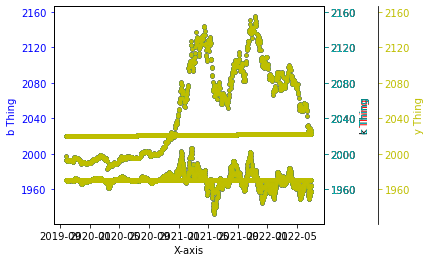

In [42]:
# Analyzing the momentum indicators together
momentum_data = bitcoin_momentum_df[["close_time", "close", "ao", "rsi", "macd"]]
momentum_data.set_index(momentum_data["close_time"], inplace=True)
fig, ax = plt.subplots()
axes = [ax, ax.twinx(), ax.twinx(), ax.twinx(), ax.twinx()]
fig.subplots_adjust(right=0.75)
axes[-1].spines['right'].set_position(('axes', 1.2))
axes[-1].set_frame_on(True)
axes[-1].patch.set_visible(False)

colors = ('b', 'r', 'k', 'c', 'y')
for ax, color in zip(axes, colors):
    data = momentum_data
    ax.plot(data, marker='.', linestyle='none', color=color)
    ax.set_ylabel('%s Thing' % color, color=color)
    ax.tick_params(axis="y", colors=color)
axes[0].set_xlabel('X-axis')

plt.show()

In [43]:
bitcoin_momentum_df.corr()

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,returns,...,fib_s3,fib_s4,fib_r1,fib_r2,fib_r3,fib_r4,macd,macd_signal,wto_1,wto_2
open,1.000000,0.998975,0.997920,0.997504,0.272081,0.543045,0.467183,0.259530,0.542910,-0.044701,...,0.997088,0.994557,0.999428,0.998980,0.997849,0.996277,0.179989,0.199812,0.044001,0.046173
high,0.998975,1.000000,0.997792,0.998896,0.280837,0.550852,0.476300,0.268311,0.550642,-0.014967,...,0.995527,0.992756,0.998656,0.998331,0.997393,0.996005,0.181683,0.200875,0.045592,0.046414
low,0.997920,0.997792,1.000000,0.998626,0.241004,0.513043,0.437151,0.229263,0.513682,-0.007828,...,0.995839,0.993687,0.996952,0.996316,0.994893,0.993044,0.184872,0.201012,0.049588,0.048311
close,0.997504,0.998896,0.998626,1.000000,0.262544,0.533330,0.457746,0.250851,0.534010,0.014764,...,0.994449,0.991854,0.997014,0.996603,0.995530,0.994015,0.186624,0.203019,0.050490,0.049233
volume,0.272081,0.280837,0.241004,0.262544,1.000000,0.895187,0.878773,0.994675,0.890960,-0.112799,...,0.243896,0.231576,0.282575,0.288340,0.297204,0.305520,-0.178581,-0.146111,-0.115947,-0.101341
quote_asset_volume,0.543045,0.550852,0.513043,0.533330,0.895187,1.000000,0.923053,0.879261,0.995262,-0.104987,...,0.516802,0.504918,0.552444,0.557519,0.565191,0.572238,-0.062795,-0.024764,-0.045858,-0.029775
number_of_trades,0.467183,0.476300,0.437151,0.457746,0.878773,0.923053,1.000000,0.866336,0.920891,-0.102660,...,0.438594,0.425884,0.477390,0.483015,0.491576,0.499508,-0.092191,-0.047240,-0.071305,-0.052820
taker_buy_base_asset_volume,0.259530,0.268311,0.229263,0.250851,0.994675,0.879261,0.866336,1.000000,0.883417,-0.098049,...,0.231924,0.219759,0.270171,0.275879,0.284660,0.292903,-0.187967,-0.152750,-0.130409,-0.114697
taker_buy_quote_asset_volume,0.542910,0.550642,0.513682,0.534010,0.890960,0.995262,0.920891,0.883417,1.000000,-0.095160,...,0.517382,0.505696,0.552377,0.557352,0.564868,0.571765,-0.071300,-0.029538,-0.054005,-0.036757
returns,-0.044701,-0.014967,-0.007828,0.014764,-0.112799,-0.104987,-0.102660,-0.098049,-0.095160,1.000000,...,-0.047432,-0.048649,-0.043189,-0.042496,-0.041398,-0.040328,0.082554,0.041588,0.124322,0.061998


In [44]:
# Creating Bollinger Bands dataframe
bbands_df = TA.BBANDS(bitcoin_df)
print(bbands_df.head())
print(bbands_df.info())

   BB_UPPER  BB_MIDDLE  BB_LOWER
0       NaN        NaN       NaN
1       NaN        NaN       NaN
2       NaN        NaN       NaN
3       NaN        NaN       NaN
4       NaN        NaN       NaN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1012 entries, 0 to 1011
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   BB_UPPER   993 non-null    float64
 1   BB_MIDDLE  993 non-null    float64
 2   BB_LOWER   993 non-null    float64
dtypes: float64(3)
memory usage: 23.8 KB
None


In [45]:
## Create dataframe with trend technical indicators
bitcoin_trend_df = bitcoin_df.assign(
  sar = lambda df: TA.SAR(df),  # Stop And Reverse
  ema = lambda df: TA.EMA(df),  # Exponential Moving Average
  sma = lambda df: TA.SMA(df),  # Simple Moving Average
  bb_upper = bbands_df["BB_UPPER"],
  bb_middle = bbands_df["BB_MIDDLE"],
  bb_lower = bbands_df["BB_LOWER"]
)

bitcoin_trend_df.head()



,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,returns,sar,ema,sma,bb_upper,bb_middle,bb_lower
0,2019-09-23,9930.13,9930.13,9930.13,9930.13,0.001000,2019-09-23 23:59:59.999,9.930130e+00,1.0,0.000000,0.000000e+00,NaN,8272.354715,9930.130000,NaN,NaN,NaN,NaN
1,2019-09-24,9637.93,9665.05,7996.45,8519.67,202.350799,2019-09-24 23:59:59.999,1.739432e+06,2345.0,125.935464,1.075624e+06,-0.142038,9930.130000,9146.541111,NaN,NaN,NaN,NaN
2,2019-09-25,8528.12,8724.77,8247.78,8435.28,55.417971,2019-09-25 23:59:59.999,4.693617e+05,763.0,29.059427,2.460492e+05,-0.009905,9930.130000,8855.040656,NaN,NaN,NaN,NaN
3,2019-09-26,8434.45,8453.20,7761.87,8064.41,41.880079,2019-09-26 23:59:59.999,3.409237e+05,1023.0,19.808849,1.611154e+05,-0.043967,9852.782800,8587.211843,NaN,NaN,NaN,NaN
4,2019-09-27,8078.75,8259.96,7858.58,8178.73,47.142904,2019-09-27 23:59:59.999,3.799180e+05,990.0,23.903742,1.927560e+05,0.014176,9727.328032,8465.697730,NaN,NaN,NaN,NaN


In [46]:
# Setting index and fixing our sh*t, yo.
bitcoin_trend_df.set_index(bitcoin_trend_df["open_time"], inplace=True)

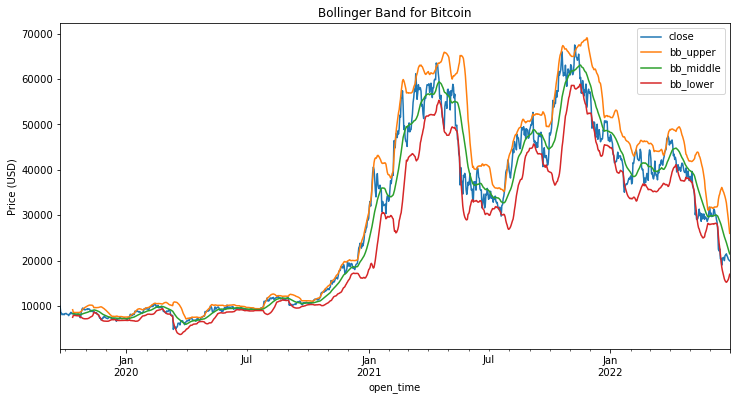

In [47]:
# Plotting our sh*t with plotly yo.
import plotly.graph_objects as go
import plotly.express as px

# Simple 30 Day Bollinger Band for Facebook (2016-2017)
# look into parabolic sar
bitcoin_trend_df[['close', 'bb_upper', 'bb_middle', 'bb_lower']].plot(figsize=(12,6))
plt.title('Bollinger Band for Bitcoin')
plt.ylabel('Price (USD)')
plt.show();

# Candlestick plot of the same shniz.
bitcoin_trend_cstkplt = go.Figure(data=[go.Candlestick(x=bitcoin_trend_df['open_time'],
                open=bitcoin_trend_df['open'],
                high=bitcoin_trend_df['high'],
                low=bitcoin_trend_df['low'],
                close=bitcoin_trend_df['close'])])

bitcoin_trend_cstkplt

In [48]:
## Create dataframe with volume technical indicators

bitcoin_volume_df = bitcoin_df.assign(
  cci = lambda df: TA.CCI(df), # Commodity Channel Index
  cmf = lambda df: TA.CHAIKIN(df), # Chaikin Money Flow
  obv = lambda df: TA.OBV(df), # On Balance Volume
  vzo = lambda df: TA.VZO(df), # Volume Oscillator
  roc = lambda df: TA.ROC(df) # Rate of Change
)

bitcoin_volume_df.head()

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,returns,cci,cmf,obv,vzo,roc
0,2019-09-23,9930.13,9930.13,9930.13,9930.13,0.001000,2019-09-23 23:59:59.999,9.930130e+00,1.0,0.000000,0.000000e+00,NaN,NaN,NaN,NaN,0.000000,NaN
1,2019-09-24,9637.93,9665.05,7996.45,8519.67,202.350799,2019-09-24 23:59:59.999,1.739432e+06,2345.0,125.935464,1.075624e+06,-0.142038,-66.666667,NaN,-202.350799,-99.999572,NaN
2,2019-09-25,8528.12,8724.77,8247.78,8435.28,55.417971,2019-09-25 23:59:59.999,4.693617e+05,763.0,29.059427,2.460492e+05,-0.009905,-64.515039,NaN,-257.768770,-99.999675,NaN
3,2019-09-26,8434.45,8453.20,7761.87,8064.41,41.880079,2019-09-26 23:59:59.999,3.409237e+05,1023.0,19.808849,1.611154e+05,-0.043967,-84.338257,NaN,-299.648849,-99.999731,NaN
4,2019-09-27,8078.75,8259.96,7858.58,8178.73,47.142904,2019-09-27 23:59:59.999,3.799180e+05,990.0,23.903742,1.927560e+05,0.014176,-70.774373,NaN,-252.505945,-63.282331,NaN


In [49]:
bitcoin_volume_df.corr()

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,returns,cci,cmf,obv,vzo,roc
open,1.000000,0.998975,0.997920,0.997504,0.272081,0.543045,0.467183,0.259530,0.542910,-0.044701,-0.025225,0.145953,-0.216866,-0.086835,0.030020
high,0.998975,1.000000,0.997792,0.998896,0.280837,0.550852,0.476300,0.268311,0.550642,-0.014967,-0.017105,0.154608,-0.210270,-0.077061,0.037710
low,0.997920,0.997792,1.000000,0.998626,0.241004,0.513043,0.437151,0.229263,0.513682,-0.007828,-0.007215,0.151002,-0.217962,-0.066149,0.043275
close,0.997504,0.998896,0.998626,1.000000,0.262544,0.533330,0.457746,0.250851,0.534010,0.014764,-0.005578,0.163326,-0.209632,-0.062048,0.049334
volume,0.272081,0.280837,0.241004,0.262544,1.000000,0.895187,0.878773,0.994675,0.890960,-0.112799,-0.160072,0.048779,-0.160395,-0.177107,-0.168796
quote_asset_volume,0.543045,0.550852,0.513043,0.533330,0.895187,1.000000,0.923053,0.879261,0.995262,-0.104987,-0.122918,0.121902,-0.123650,-0.194898,-0.100271
number_of_trades,0.467183,0.476300,0.437151,0.457746,0.878773,0.923053,1.000000,0.866336,0.920891,-0.102660,-0.145268,0.113183,-0.167747,-0.209544,-0.115760
taker_buy_base_asset_volume,0.259530,0.268311,0.229263,0.250851,0.994675,0.879261,0.866336,1.000000,0.883417,-0.098049,-0.170588,0.037438,-0.183241,-0.175717,-0.188672
taker_buy_quote_asset_volume,0.542910,0.550642,0.513682,0.534010,0.890960,0.995262,0.920891,0.883417,1.000000,-0.095160,-0.130529,0.113961,-0.153445,-0.196565,-0.115432
returns,-0.044701,-0.014967,-0.007828,0.014764,-0.112799,-0.104987,-0.102660,-0.098049,-0.095160,1.000000,0.333024,0.258932,0.117024,0.424494,0.287800


In [50]:
bitcoin_strategy_df = bitcoin_df.assign(
  sma = lambda df: TA.SMA(df), # Single Moving Average
  cci = lambda df: TA.CCI(df), # Commodity Channel Index
  macd = macd_df["MACD"], # Moving Average Convergence Divergence
  macd_signal = macd_df["SIGNAL"],
  bb_upper = bbands_df["BB_UPPER"], # Bollinger Band
  bb_middle = bbands_df["BB_MIDDLE"],
  bb_lower = bbands_df["BB_LOWER"]
)

bitcoin_strategy_df.tail()

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,returns,sma,cci,macd,macd_signal,bb_upper,bb_middle,bb_lower
1007,2022-06-26,21489.82,21882.15,20979.11,21047.27,586.391143,2022-06-26 23:59:59.999,1.253645e+07,17433.0,282.990557,6.054924e+06,-0.020719,26757.789024,-42.498644,-2369.354608,-2533.201446,31584.582474,23466.7040,15348.825526
1008,2022-06-27,21035.02,21538.40,20520.44,20729.39,706.578276,2022-06-27 23:59:59.999,1.482989e+07,21305.0,363.592474,7.630949e+06,-0.015103,26520.720244,-45.756493,-2274.719123,-2481.504981,30296.535734,22947.2135,15597.891266
1009,2022-06-28,20735.95,21210.85,20197.04,20280.68,1245.636970,2022-06-28 23:59:59.999,2.573792e+07,25714.0,616.997369,1.274749e+07,-0.021646,26316.466829,-51.012009,-2210.446317,-2427.293248,29035.999740,22450.7315,15865.463260
1010,2022-06-29,20275.20,20439.60,19851.47,20117.99,2589.682853,2022-06-29 23:59:59.999,5.212092e+07,47615.0,1277.566008,2.571288e+07,-0.008022,26067.611951,-62.232199,-2147.877978,-2371.410194,27529.983988,21951.3010,16372.618012
1011,2022-06-30,20129.62,20170.34,18634.59,19940.13,3450.195515,2022-06-30 23:59:59.999,6.651257e+07,61746.0,1679.936083,3.238200e+07,-0.008841,25841.664146,-85.293534,-2088.568220,-2314.841799,26005.449103,21493.6920,16981.934897


In [51]:
## Develop ways to create signals

#cci 
      #Buy when the line moves above –100 from below and sell when it drops below +100 (see arrow at “E”) or any time it rises above +200. If it does rise above +200, some traders prefer to wait until it drops below that level to sell.
 
      #Buy whenever the line crosses below –200 or wait until it crosses back above –200. Sell when it crosses from above to below +100.
      # df.ta.categories
macd_df.ta.categories 

def MACD_Strategy(macd_df):
    MACD_Buy=[]
    MACD_Sell=[]
    position=False

    for i in range(0, len(macd_df)):
        if macd_df ['MACD'][i] > macd_df['SIGNAL'][i] :
            MACD_Sell.append(np.nan)
            if position ==False:
                MACD_Buy.append(macd_df['Adj Close'][i])
                position=True
            else:
                MACD_Buy.append(np.nan)
        elif macd_df ['SIGNAL'][i] < macd_df['MACD'][i] :
            MACD_Buy.append(np.nan)
            if position == True:
                MACD_Sell.append(macd_df['Adj Close'][i])
                position=False
            else:
                MACD_Sell.append(np.nan)
        elif position == True and macd_df ['Adj Close'][i] < MACD_Buy[-1] :
            MACD_Sell.append(macd_df ["Adj Close"][i])
            MACD_Buy.append(np.nan)
            position = False
        elif position == True and macd_df ['Adj Close'][i] < macd_df['Adj Close']:
            MACD_Sell.append(macd_df ["Adj Close"][i])
            MACD_Buy.append(np.nan)
            position = False
        else:
            MACD_Buy.append(np.nan)
            MACD_Sell.append(np.nan)

    data['MACD_Buy_Signal_price'] = MACD_Buy
    data['MACD_Sell_Signal_price'] = MACD_Sell

    return data

data = MACD_Strategy

MACD_Strategy(macd_df).plot()

KeyError: 'Adj Close'

In [ ]:
## CCI Signals
bitcoin_strategy_df['cci_signals'] = np.nan

# Loop through the Pandas DataFrame and code the conditions of the trading strategy 
for index, row in bitcoin_strategy_df.iterrows():
    
    # buy if the previous price is 0, in other words, buy on the first day
    # set the cost/proceeds column equal to the negative value of the row close price
    # multiplied by the share_size
    if row["cci"] < -120:
        bitcoin_strategy_df.loc[index, "cci_signals"] = 1

    # buy if the current day price is less than the previous day price
    # set the cost/proceeds column equal to the negative value of the row close price
    # multiplied by the share_size
    elif row["cci"] > 120:
        bitcoin_strategy_df.loc[index, "cci_signals"] = -1

    # else hold if the current day price is equal to the previous day price
    else:
        bitcoin_strategy_df.loc[index, "cci_signals"] = 0
    
    

    #if index == amd_df.index[-1]:
     #   amd_df.loc[index, "trade_type"] = "sell"

In [ ]:
## MACD Signals
bitcoin_strategy_df['mc_signals'] = np.nan

# Loop through the Pandas DataFrame and code the conditions of the trading strategy 
for index, row in bitcoin_strategy_df.iterrows():
    
    # buy if MACD line turns up and crosses above the MACD_SIGNAL line
        # if MACD number is less than the MACD_SIGNAL on 
        #   row[0]  MACD < MACD_SIGNAL  
            # Jan 15, 2020   200 < 300
        # and if MACD number is greater than the MACD_SIGNAL on 
        #   row[1]  MACD > MACD_SIGNAL
            # Jan 16, 2020   300 > 200
    # sell if MACD line turns down and crosses below the MACD_SIGNAL line
        # if MACD number is greater than the MACD_SIGNAL on
        #   row[0]  MACD > MACD_SIGNAL
            # Jan 15, 2020   300 > 200
        # and if MACD number is less than the MACD_SIGNAL on
        #   row[1]  MACD < MACD_SIGNAL
            # Jan 16, 2020   200 < 300    
    # hold if MACD line does NOT cross over the MACD_SIGNAL line






    # buy if the previous price is 0, in other words, buy on the first day
    # set the cost/proceeds column equal to the negative value of the row close price
    # multiplied by the share_size
    if row["cci"] < -120:
        bitcoin_strategy_df.loc[index, "cci_signals"] = 1

    # buy if the current day price is less than the previous day price
    # set the cost/proceeds column equal to the negative value of the row close price
    # multiplied by the share_size
    elif row["cci"] > 120:
        bitcoin_strategy_df.loc[index, "cci_signals"] = -1

    # else hold if the current day price is equal to the previous day price
    else:
        bitcoin_strategy_df.loc[index, "cci_signals"] = 0
    
    

    #if index == amd_df.index[-1]:
     #   amd_df.loc[index, "trade_type"] = "sell"

In [ ]:
## Bollinger Band Signals
bitcoin_strategy_df['bb_signals'] = np.nan

# Loop through the Pandas DataFrame and code the conditions of the trading strategy 
for index, row in bitcoin_strategy_df.iterrows():
    
    # buy if MACD line turns up and crosses above the MACD_SIGNAL line

    # sell if MACD line turns down and crosses below the MACD_SIGNAL line

    # hold if MACD line does NOT cross over the MACD_SIGNAL line






    # buy if the previous price is 0, in other words, buy on the first day
    # set the cost/proceeds column equal to the negative value of the row close price
    # multiplied by the share_size
    if row["cci"] < -120:
        bitcoin_strategy_df.loc[index, "cci_signals"] = 1

    # buy if the current day price is less than the previous day price
    # set the cost/proceeds column equal to the negative value of the row close price
    # multiplied by the share_size
    elif row["cci"] > 120:
        bitcoin_strategy_df.loc[index, "cci_signals"] = -1

    # else hold if the current day price is equal to the previous day price
    else:
        bitcoin_strategy_df.loc[index, "cci_signals"] = 0
    
    

    #if index == amd_df.index[-1]:
     #   amd_df.loc[index, "trade_type"] = "sell"

In [ ]:
bitcoin_strategy_df.head(10)

### Section 3. Feature evaluation and feature engineering with RandomForest

In [ ]:
# Initializing sklearn imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

#### Evaluating Momentum Indicator Algorithm


In [ ]:
bitcoin_momentum_features = bitcoin_momentum_df.copy().dropna()

In [ ]:
# Define momentum indicator features
X = bitcoin_momentum_features.copy()
X.drop(["open_time", "close_time", "close", "returns"], axis=1, inplace=True)
X.head()

In [ ]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Create the StandardScaler instance
scaler = StandardScaler()

# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

# Scale the training data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
# Create the random forest classifier instance
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [ ]:
# Fit the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

### Section 4. Development of preliminary crypto-trading strategy by identifying best features/indicators

### Section 5. Data visualization and dashboarding

### Section 6. Deep learning with TensorFlow for Predictive Modeling

### Section 7. Backtesting and model evaluation